In [1]:
import os
import logging
import time
import sys
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
from PIL import Image

# Configure logging
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s: %(message)s',
    handlers=[
        logging.FileHandler('kidney_tumor_training.log', mode='w'),
        logging.StreamHandler(sys.stdout)
    ]
)

In [2]:
def load_kidney_tumor_data(excel_path, base_scan_path):
    logging.info(f"Starting data loading from {excel_path} and Train folder")
    start_time = time.time()
    
    # Load data from excel file
    df = pd.read_excel(excel_path)
    df['binary_label'] = df['Situation'].map({
        'Tumor': 1, 
        'Normal case with cyst': 0, 
        'Normal case': 0
    })
    
    image_paths = []
    labels = []
    skipped_patients = 0
    
    # Load data from original dataset
    for patient_id in df.index:
        patient_folder = os.path.join(base_scan_path, f"{patient_id:02d}")
        
        if os.path.exists(patient_folder):
            patient_label = df.loc[patient_id, 'binary_label']
            
            for subfolder in os.listdir(patient_folder):
                subfolder_path = os.path.join(patient_folder, subfolder)
                
                if os.path.isdir(subfolder_path):
                    for img_file in os.listdir(subfolder_path):
                        if img_file.endswith('.jpg'):
                            img_path = os.path.join(subfolder_path, img_file)
                            image_paths.append(img_path)
                            labels.append(patient_label)
        else:
            skipped_patients += 1

    # Load additional training data from Train folder
    train_folder = 'Train'
    
    # Load normal images
    normal_folder = os.path.join(train_folder, 'Normal')
    if os.path.exists(normal_folder):
        for img_file in os.listdir(normal_folder):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(normal_folder, img_file)
                image_paths.append(img_path)
                labels.append(0)

    # Load tumor images
    tumor_folder = os.path.join(train_folder, 'Tumor')
    if os.path.exists(tumor_folder):
        for img_file in os.listdir(tumor_folder):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(tumor_folder, img_file)
                image_paths.append(img_path)
                labels.append(1)
    
    logging.info(f"Data Loading Time: {time.time() - start_time:.2f} seconds")
    logging.info(f"Total Images: {len(image_paths)}")
    logging.info(f"Skipped Patients: {skipped_patients}")
    logging.info(f"Class Distribution:")
    logging.info(f"  Negative Class: {labels.count(0)} ({labels.count(0)/len(labels)*100:.2f}%)")
    logging.info(f"  Positive Class: {labels.count(1)} ({labels.count(1)/len(labels)*100:.2f}%)")
    
    return image_paths, labels

In [3]:
class KidneyTumorDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # ResNet standard input size
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
            image = self.transform(image)
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            return image, label
        except Exception as e:
            logging.error(f"Error processing image {self.image_paths[idx]}: {e}")
            return None, None

In [4]:
def create_data_loaders(image_paths, labels, batch_size=32):
    logging.info("Creating train-validation split")
    start_time = time.time()
    
    X_train, X_val, y_train, y_val = train_test_split(
        image_paths, labels, 
        test_size=0.2, 
        stratify=labels, 
        random_state=42
    )
    
    train_dataset = KidneyTumorDataset(X_train, y_train)
    val_dataset = KidneyTumorDataset(X_val, y_val)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0
    )
    
    logging.info(f"Data Loader Creation Time: {time.time() - start_time:.2f} seconds")
    logging.info(f"Train Batches: {len(train_loader)}")
    logging.info(f"Validation Batches: {len(val_loader)}")
    
    return train_loader, val_loader

In [5]:
class ResNetTumorClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Freeze base network weights
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Replace final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.resnet(x)

In [6]:
def train_model(model, train_loader, val_loader, epochs=50):
    logging.info("Starting Model Training")
    total_start_time = time.time()
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    device = torch.device('cpu')
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        total_correct = 0
        total_samples = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            if images is None or labels is None:
                continue
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            predictions = (outputs > 0.5).float()
            total_correct += (predictions == labels).float().sum().item()
            total_samples += labels.size(0)
            
            if batch_idx % 10 == 0:
                logging.info(f"Epoch {epoch+1}, Batch {batch_idx}: Loss = {loss.item():.4f}")
        
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                if images is None or labels is None:
                    continue
                
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze()
                val_loss = criterion(outputs, labels)
                
                total_val_loss += val_loss.item()
                predictions = (outputs > 0.5).float()
                total_val_correct += (predictions == labels).float().sum().item()
                total_val_samples += labels.size(0)
        
        train_accuracy = total_correct / total_samples
        val_accuracy = total_val_correct / total_val_samples
        
        train_losses.append(total_train_loss/len(train_loader))
        val_losses.append(total_val_loss/len(val_loader))
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        logging.info(f"Epoch {epoch+1} Summary:")
        logging.info(f"  Train Loss: {train_losses[-1]:.4f}")
        logging.info(f"  Train Accuracy: {train_accuracy:.4f}")
        logging.info(f"  Validation Loss: {val_losses[-1]:.4f}")
        logging.info(f"  Validation Accuracy: {val_accuracy:.4f}")
        logging.info(f"  Epoch Time: {time.time() - epoch_start_time:.2f} seconds")
    
    # Plot Training Metrics
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Loss')
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Accuracy')
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    logging.info("Training metrics plot saved")
    
    logging.info(f"Total Training Time: {time.time() - total_start_time:.2f} seconds")
    return model

In [7]:
def evaluate_model(model, val_loader):
    logging.info("Starting Model Evaluation")
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            if images is None or labels is None:
                continue
            
            outputs = model(images).squeeze()
            probabilities = outputs
            predictions = (outputs > 0.5).float()
            
            all_preds.extend(predictions.numpy())
            all_probs.extend(probabilities.numpy())
            all_labels.extend(labels.numpy())
    
    # Classification Report
    report = classification_report(all_labels, all_preds)
    logging.info("\nClassification Report:\n" + report)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    logging.info("\nConfusion Matrix:\n" + str(cm))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix.png')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    
    logging.info("Evaluation visualizations saved")
    
    return report, cm

In [8]:
def save_model(model, filepath='kidney_tumor_resnet_model.pth'):
    logging.info(f"Saving model to {filepath}")
    torch.save(model.state_dict(), filepath)
    logging.info("Model saved successfully")

In [9]:
def load_model(model, filepath='kidney_tumor_resnet_model.pth'):
    logging.info(f"Loading model from {filepath}")
    model.load_state_dict(torch.load(filepath))
    model.eval()
    logging.info("Model loaded successfully")
    return model

In [10]:
def test_model_on_dataset(model, excel_path, base_scan_path):
    logging.info("Starting model testing")
    image_paths, labels = load_kidney_tumor_data(excel_path, base_scan_path)
    
    test_dataset = KidneyTumorDataset(image_paths, labels)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            if images is None or labels is None:
                continue
            
            outputs = model(images).squeeze()
            predictions = (outputs > 0.5).float()
            
            all_preds.extend(predictions.numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    logging.info(f"Test Accuracy: {accuracy:.4f}")
    return accuracy, all_preds, all_labels

2025-02-06 21:27:46,637 - INFO: Starting data loading from Dataset/00Kidney_Patients.xlsx and Train folder
2025-02-06 21:27:47,233 - INFO: Data Loading Time: 0.59 seconds
2025-02-06 21:27:47,233 - INFO: Total Images: 13588
2025-02-06 21:27:47,233 - INFO: Skipped Patients: 10
2025-02-06 21:27:47,233 - INFO: Class Distribution:
2025-02-06 21:27:47,249 - INFO:   Negative Class: 7631 (56.16%)
2025-02-06 21:27:47,252 - INFO:   Positive Class: 5957 (43.84%)
2025-02-06 21:27:47,253 - INFO: Creating train-validation split
2025-02-06 21:27:47,253 - INFO: Data Loader Creation Time: 0.00 seconds
2025-02-06 21:27:47,267 - INFO: Train Batches: 340
2025-02-06 21:27:47,269 - INFO: Validation Batches: 85


C:\Users\aksha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aksha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2025-02-06 21:27:47,545 - INFO: Starting Model Training
2025-02-06 21:27:49,280 - INFO: Epoch 1, Batch 0: Loss = 0.7005
2025-02-06 21:28:04,239 - INFO: Epoch 1, Batch 10: Loss = 0.7294
2025-02-06 21:28:17,307 - INFO: Epoch 1, Batch 20: Loss = 0.7000
2025-02-06 21:28:30,183 - INFO: Epoch 1, Batch 30: Loss = 0.6465
2025-02-06 21:28:43,066 - INFO: Epoch 1, Batch 40: Loss = 0.6469
2025-02-06 21:28:56,226 - INFO: Epoch 1, Batch 50: Loss = 0.6345
2025-02-06 21:29:09,299 - INFO: Epoch 1, Batch 60: Loss = 0.6291
2025-02-06 21:29:22,278 - INFO: Epoch 1, Batch 70: Loss = 0.6613
2025-02-06 21:29:35,197 - INFO: Epoch 1, Batch 80: Loss = 0.5993
2025-02-06 21:29:48,220 - INFO: Epoch 1, Batch 90: Loss = 0.6798
2025-02-06 21:30:01,135 - INFO: Epoch 1, Batch 100: Loss = 0.6375
2025-02-06 21:30:16,287 - INFO: Epoch 1, Batch 110: Loss = 0.6533
2025-02-06 21:30:29,565 - INFO: Epoch 1, Batch 120: Loss = 0.7277
2025-02-06 21:30:42,822 - INFO: Epoch 1, Batch 130: Loss = 0.5612
2025-02-06 21:30:56,127 - INFO:

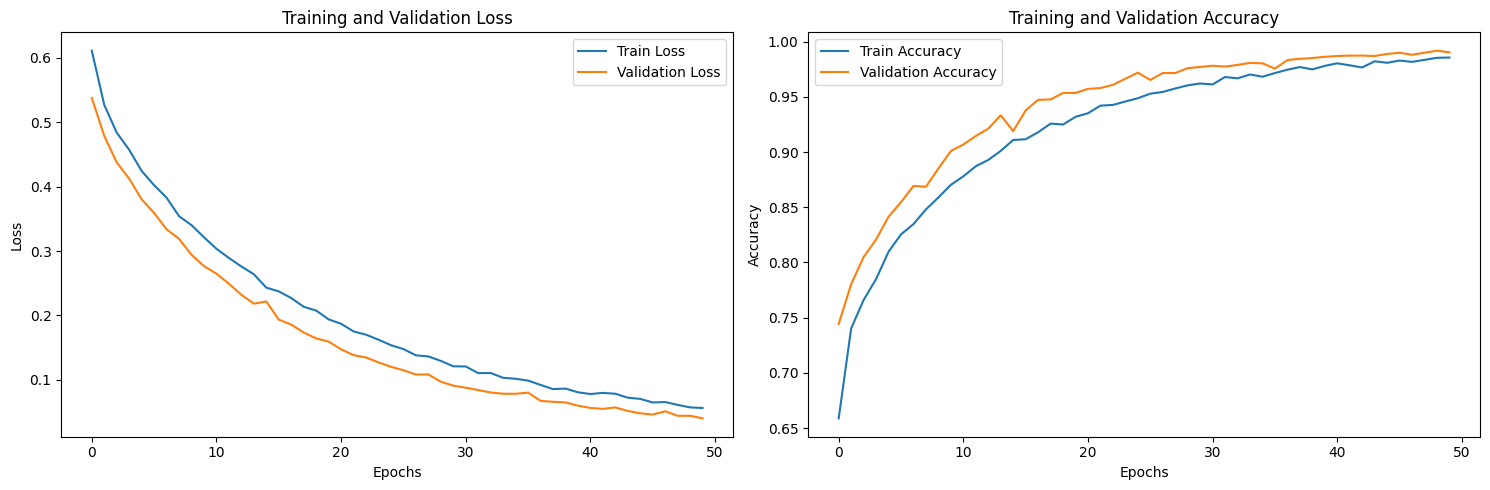

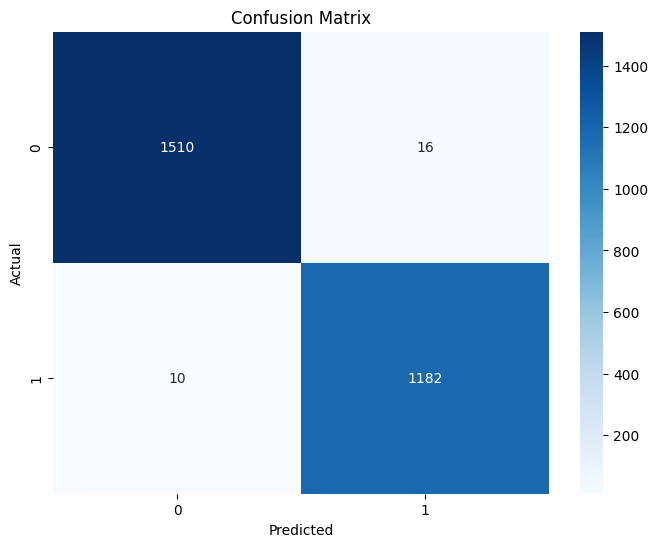

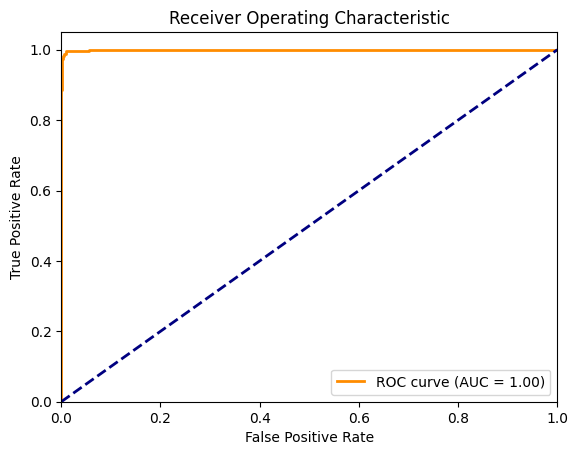

In [11]:
def main():
    # Data preparation
    excel_path = 'Dataset/00Kidney_Patients.xlsx'
    base_scan_path = 'unzipped_scans'
    
    # Load data
    image_paths, labels = load_kidney_tumor_data(excel_path, base_scan_path)
    
    # Create data loaders
    train_loader, val_loader = create_data_loaders(image_paths, labels)
    
    # Initialize model
    model = ResNetTumorClassifier()
    
    # Train model
    trained_model = train_model(model, train_loader, val_loader)
    
    # Evaluate model
    eval_report, conf_matrix = evaluate_model(trained_model, val_loader)
    
    # Save model
    save_model(trained_model)
    
    # Test model on dataset
    test_accuracy, test_preds, test_labels = test_model_on_dataset(
        trained_model, excel_path, base_scan_path
    )

if __name__ == '__main__':
    main()

In [13]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import logging
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time

# Configure logging with timestamp and both file and console output
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s: %(message)s',
    handlers=[
        logging.FileHandler('test_results.log', mode='w'),
        logging.StreamHandler()
    ]
)

class ResNetTumorClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        logging.info("Initializing ResNetTumorClassifier")
        self.resnet = models.resnet18(pretrained=True)
        
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )
        logging.info("ResNetTumorClassifier initialized successfully")
    
    def forward(self, x):
        return self.resnet(x)

class TestDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        logging.info(f"Initializing TestDataset with {len(image_paths)} images")
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        try:
            image_path = self.image_paths[idx]
            logging.debug(f"Processing image: {image_path}")
            
            image = Image.open(image_path).convert('RGB')
            image = self.transform(image)
            return image, self.labels[idx], image_path
        except Exception as e:
            logging.error(f"Error processing image {image_path}: {e}")
            return None, None, None

def collect_test_data(test_folder):
    """Collect image paths and labels from test folder structure"""
    logging.info(f"Starting to collect test data from {test_folder}")
    start_time = time.time()
    
    image_paths = []
    labels = []
    
    # Collect normal images
    normal_folder = os.path.join(test_folder, 'Normal')
    logging.info(f"Scanning Normal folder: {normal_folder}")
    normal_count = 0
    for img_name in os.listdir(normal_folder):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(normal_folder, img_name))
            labels.append(0)
            normal_count += 1
    logging.info(f"Found {normal_count} normal images")
    
    # Collect tumor images
    tumor_folder = os.path.join(test_folder, 'Tumor')
    logging.info(f"Scanning Tumor folder: {tumor_folder}")
    tumor_count = 0
    for img_name in os.listdir(tumor_folder):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(tumor_folder, img_name))
            labels.append(1)
            tumor_count += 1
    logging.info(f"Found {tumor_count} tumor images")
    
    logging.info(f"Data collection completed in {time.time() - start_time:.2f} seconds")
    logging.info(f"Total images found: {len(image_paths)}")
    
    return image_paths, labels

def evaluate_model(model, test_loader):
    """Evaluate model performance"""
    logging.info("Starting model evaluation")
    start_time = time.time()
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    image_results = []
    
    total_batches = len(test_loader)
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_idx, (images, labels, paths) in enumerate(test_loader, 1):
            if images is None:
                continue
            
            # Log progress every few batches
            if batch_idx % 5 == 0 or batch_idx == total_batches:
                logging.info(f"Processing batch {batch_idx}/{total_batches}")
            
            outputs = model(images).squeeze(1)
            probabilities = outputs.numpy()
            predictions = (outputs > 0.5).float().numpy()
            
            # Calculate accuracy for this batch
            correct = (predictions == labels.numpy()).sum()
            correct_predictions += correct
            total_predictions += len(predictions)
            
            # Store results
            for i in range(len(paths)):
                image_results.append({
                    'path': paths[i],
                    'true_label': labels[i].item(),
                    'predicted': predictions[i],
                    'probability': probabilities[i]
                })
            
            all_preds.extend(predictions)
            all_labels.extend(labels.numpy())
            all_probs.extend(probabilities)
    
    # Log evaluation summary
    accuracy = correct_predictions / total_predictions
    logging.info(f"Evaluation completed in {time.time() - start_time:.2f} seconds")
    logging.info(f"Running accuracy: {accuracy:.4f}")
    
    return all_preds, all_labels, all_probs, image_results

def plot_results(all_labels, all_preds, all_probs):
    """Plot confusion matrix and ROC curve"""
    logging.info("Generating result plots")
    start_time = time.time()
    
    plt.figure(figsize=(10, 4))
    
    # Confusion Matrix
    logging.info("Creating confusion matrix")
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # ROC Curve
    logging.info("Creating ROC curve")
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig('test_results.png')
    plt.close()
    
    logging.info(f"Plots generated and saved in {time.time() - start_time:.2f} seconds")

def test_model(model_path, test_folder, batch_size=32):
    """Main testing function"""
    logging.info("="*50)
    logging.info("Starting model testing process")
    logging.info("="*50)
    
    total_start_time = time.time()
    
    try:
        # Load model
        logging.info(f"Loading model from {model_path}")
        model_load_start = time.time()
        model = ResNetTumorClassifier()
        model.load_state_dict(torch.load(model_path))
        model.eval()
        logging.info(f"Model loaded in {time.time() - model_load_start:.2f} seconds")
        
        # Collect test data
        image_paths, labels = collect_test_data(test_folder)
        
        # Create test dataset and loader
        logging.info("Creating test DataLoader")
        loader_start = time.time()
        test_dataset = TestDataset(image_paths, labels)
        test_loader = DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False,
            num_workers=0
        )
        logging.info(f"DataLoader created in {time.time() - loader_start:.2f} seconds")
        logging.info(f"Number of batches: {len(test_loader)}")
        
        # Evaluate model
        logging.info("Starting model evaluation")
        all_preds, all_labels, all_probs, image_results = evaluate_model(model, test_loader)
        
        # Generate classification report
        logging.info("Generating classification report")
        report = classification_report(all_labels, all_preds, target_names=['Normal', 'Tumor'])
        logging.info("\nClassification Report:\n" + report)
        
        # Plot results
        plot_results(all_labels, all_preds, all_probs)
        
        # Save detailed results to CSV
        logging.info("Saving detailed results to CSV")
        df_results = pd.DataFrame(image_results)
        df_results['correct'] = df_results['true_label'] == df_results['predicted']
        df_results.to_csv('test_results.csv', index=False)
        
        # Print summary statistics
        logging.info("\nTest Results Summary:")
        logging.info(f"Total images tested: {len(df_results)}")
        logging.info(f"Correct predictions: {df_results['correct'].sum()}")
        logging.info(f"Accuracy: {df_results['correct'].mean():.2%}")
        
        # Analysis by class
        for label in [0, 1]:
            class_name = 'Normal' if label == 0 else 'Tumor'
            class_data = df_results[df_results['true_label'] == label]
            correct = class_data['correct'].sum()
            total = len(class_data)
            logging.info(f"\n{class_name} class:")
            logging.info(f"Correct: {correct}/{total} ({correct/total:.2%})")
        
        total_time = time.time() - total_start_time
        logging.info(f"\nTotal testing time: {total_time:.2f} seconds")
        logging.info("="*50)
        logging.info("Testing process completed")
        logging.info("="*50)
        
        return df_results
        
    except Exception as e:
        logging.error(f"Error in testing: {e}")
        return None

if __name__ == "__main__":
    # Define paths
    MODEL_PATH = 'kidney_tumor_resnet_model.pth'
    TEST_FOLDER = 'Test'  # This contains 'Normal' and 'Tumor' subfolders
    
    # Run testing
    results = test_model(MODEL_PATH, TEST_FOLDER)

2025-02-07 08:31:50,712 - INFO: ==================================================
2025-02-07 08:31:50,713 - INFO: Starting model testing process
2025-02-07 08:31:50,715 - INFO: ==================================================
2025-02-07 08:31:50,715 - INFO: Loading model from kidney_tumor_resnet_model.pth
2025-02-07 08:31:50,717 - INFO: Initializing ResNetTumorClassifier
2025-02-07 08:31:50,976 - INFO: ResNetTumorClassifier initialized successfully
2025-02-07 08:31:51,054 - INFO: Model loaded in 0.34 seconds
2025-02-07 08:31:51,054 - INFO: Starting to collect test data from Test
2025-02-07 08:31:51,070 - INFO: Scanning Normal folder: Test\Normal
2025-02-07 08:31:51,075 - INFO: Found 1016 normal images
2025-02-07 08:31:51,076 - INFO: Scanning Tumor folder: Test\Tumor
2025-02-07 08:31:51,079 - INFO: Found 457 tumor images
2025-02-07 08:31:51,080 - INFO: Data collection completed in 0.01 seconds
2025-02-07 08:31:51,081 - INFO: Total images found: 1473
2025-02-07 08:31:51,082 - INFO: Cr